In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from palettable.cartocolors.qualitative import Vivid_5
import numpy as np
plt.style.use("publication")

In [135]:
tmc1_preds = pd.read_csv("../../scripts/tmc1_results.csv")

In [403]:
H2_CD = 1e22

tmc1_preds["ObsAbundance"] = tmc1_preds["Column density (cm^-2)"] / H2_CD
tmc1_preds["LinearAbundance"] = 10**tmc1_preds["linear"] / H2_CD
tmc1_preds["MLError"] = 10**(np.abs(np.log10(tmc1_preds["LinearAbundance"] / tmc1_preds["ObsAbundance"])))

In [404]:
molecules = ["HC11N", "H2CS", "H2CO", "C6H5CN", "C11H7N"]
labels = ["HC$_{11}$N", "H$_2$CS", "H$_2$CO", "C$_6$H$_5$CN", "C$_{10}$H$_7$CN"]

In [405]:
temp = tmc1_preds.loc[tmc1_preds["Formula"].isin(molecules)].drop_duplicates(["Formula"])

In [406]:
obs_abundance = temp["ObsAbundance"].values

In [407]:
test = pd.read_csv("../../data/external/nautilus/ab/HC9N.ab", header=None, names=["T", "X"], skiprows=1, delim_whitespace=True)

In [408]:
new_df = pd.DataFrame(temp["MLError"].tolist())

In [409]:
new_df.index = labels

In [410]:
top_index = test["X"].argmax()

In [411]:
def get_molecule_abundance(molecule: str, index: int = 810) -> float:
    if molecule == "C11H7N":
        molecule = "C10H7CN"
    temp = pd.read_csv(f"../../data/external/nautilus/ab/{molecule}.ab", header=None, names=["T", "X"], skiprows=1, delim_whitespace=True)
    return temp.iloc[index]["X"]

In [412]:
new_df["ChemModelError"] = 10**(np.abs(np.log10(np.array(list(map(get_molecule_abundance, molecules))) / obs_abundance)))

In [413]:
list(map(get_molecule_abundance, molecules))

[2.262075e-10, 9.144201e-10, 6.581461e-09, 9.1893e-13, 1.755698e-15]

In [414]:
(1e-15 - 1.2e-9) / 1.2e-9

-0.9999991666666668

In [415]:
new_df.columns = ["Linear regression", "GOTHAM Nautilus"]

In [416]:
new_df

,Linear regression,GOTHAM Nautilus
HC$_{11}$N,7.019548,18.434402
H$_2$CS,1.612473,8.792501
H$_2$CO,1.430233,89.543687
C$_6$H$_5$CN,1.333964,188.262436
C$_{10}$H$_7$CN,1.016828,683488.846032


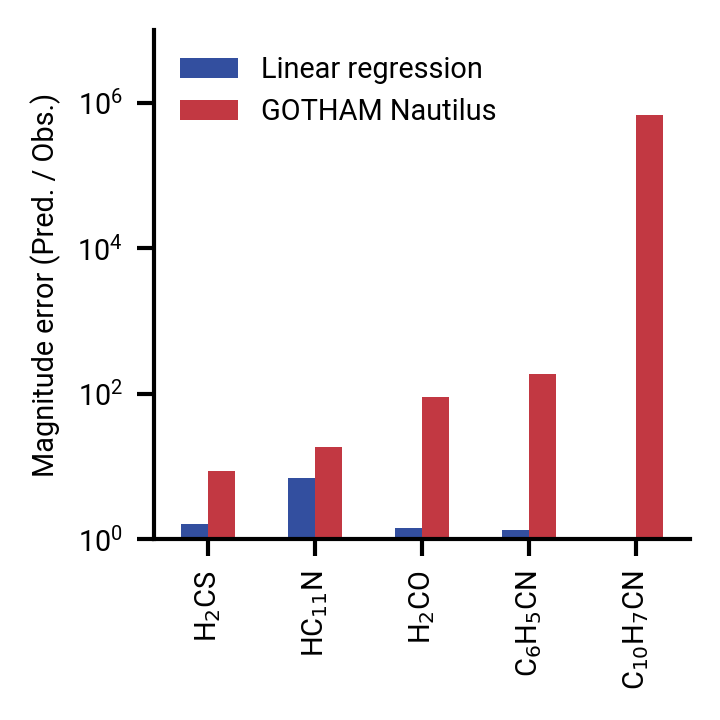

In [420]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

new_df.sort_values(["GOTHAM Nautilus"], ascending=True).plot(kind="bar", ax=ax)
ax.set(ylabel="Magnitude error (Pred. / Obs.)", yscale="log", ylim=[1., 1e7])
ax.legend(fontsize="x-small", loc="upper left")
# ax.axhline(1., 0., 1., ls="--", alpha=0.3)
fig.savefig("../../reports/figures/ml_model_comparison.pdf", dpi=300)

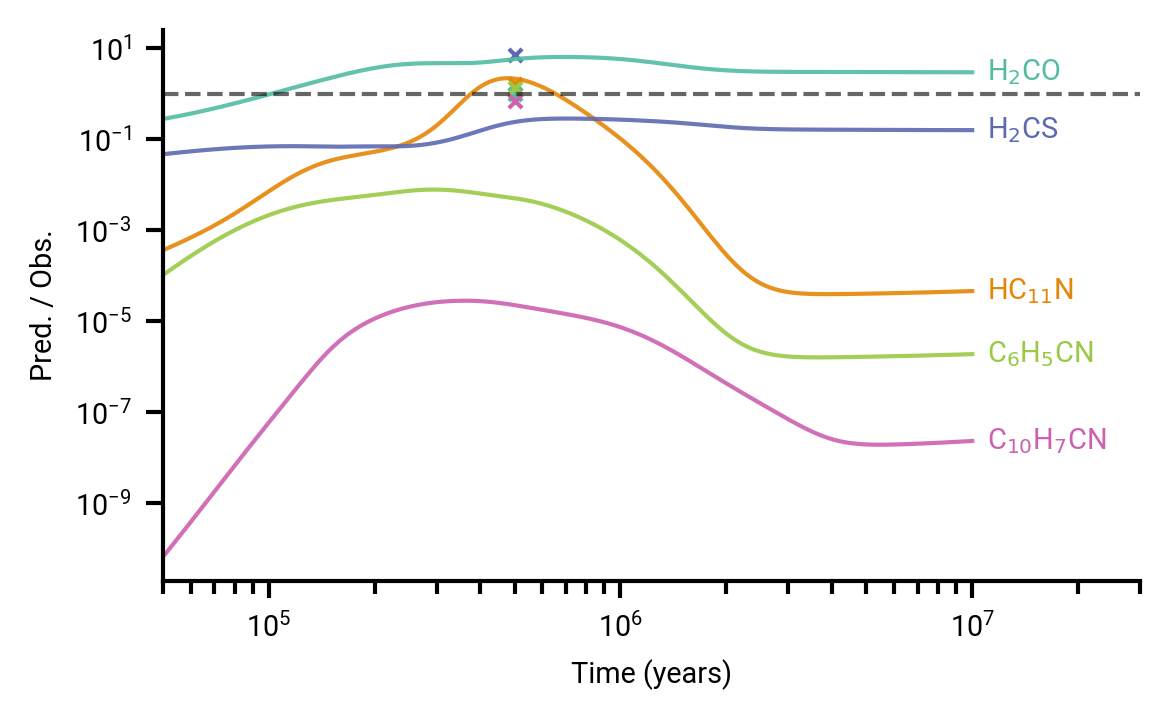

In [8]:
fig, ax = plt.subplots(figsize=(4., 2.5))

colors = Vivid_5.hex_colors

zero, end = 5e4, 1e7

tmc1_preds["X"] = (10**tmc1_preds["linear"]) / 1e22
tmc1_preds["Obs X"] = tmc1_preds["Column density (cm^-2)"] / 1e22

for color, molecule, label in zip(colors, molecules, labels):
    temp = tmc1_preds.loc[tmc1_preds["Formula"] == molecule]
    obs_X = temp["Obs X"].values[0]
    pred_X = temp["X"].values[0]
    # load in the model data
    if molecule == "C11H7N":
        molecule = "C10H7CN"
    model_data = pd.read_csv(f"../../data/external/nautilus/ab/{molecule}.ab", header=None, names=["T", "X"], skiprows=1, delim_whitespace=True)
    model_data = model_data.loc[model_data["T"] > zero]
    model_data["Ratio"] = model_data["X"] / obs_X
    ax.plot(model_data["T"], model_data["Ratio"], color=color, alpha=0.9)
    ax.text(model_data["T"].max() * 1.1, model_data["Ratio"].iloc[-1], label, fontsize="x-small", color=color, horizontalalignment="left", verticalalignment="center")
    ax.scatter(5e5, pred_X / obs_X, color=color, marker="x", s=10.)
ax.set(xscale="log", xlim=[zero, end * 3], yscale="log", ylabel="Pred. / Obs.", xlabel="Time (years)")
ax.axhline(1., ls="--", alpha=0.6)
fig.savefig("../../reports/figures/ml_model_comparison.pdf", dpi=300)